## Chapter 3 - Classification
## MNIST

In [526]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [527]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [528]:
X, y = mnist["data"], mnist["target"]

In [529]:
X.shape

(70000, 784)

In [530]:
y.shape

(70000,)

Saving figure some_digit_plot


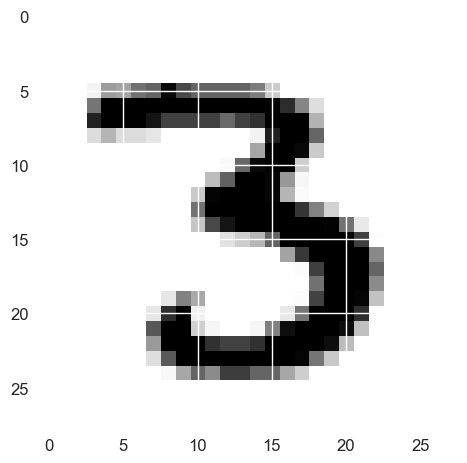

In [531]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[12]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
#plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [532]:
y[12]

'3'

In [533]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [534]:
## Convert to integer for ML

In [535]:
y = y.astype(np.uint8)

### Training a binary classifier
##### We will a) train a binary classifier, b) choose the appropriate metric for the task, c) evaludate the classifiers using cross-validation, d) select the precision/recall tradeoff that fits our needs, and e) use ROC curves and ROC AUC scores to compare various models
#### Need to make a test and train set first!

In [536]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [537]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [538]:
from sklearn.linear_model import SGDClassifier

In [539]:
sgd_clf = SGDClassifier(random_state=69)

In [540]:
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(random_state=69)

In [541]:
sgd_clf.predict([some_digit])

array([ True])

### Measuring accuracy using Cross-Validation

#### Manual cross_validation score, NOT using Sklearn, good for when need for control

In [542]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [543]:
skfolds = StratifiedKFold(n_splits=3)

In [544]:
for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_3[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_3[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96325
0.96635
0.93765


#### Normal Sklearn cross-validation

In [545]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.96325, 0.96635, 0.93765])

In [546]:
from sklearn.base import BaseEstimator

In [547]:
class Never3Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [548]:
never_3_clf = Never3Classifier()

In [549]:
cross_val_score(never_3_clf, X_train, y_train_3, cv=3, scoring = "accuracy")

array([0.8962 , 0.89975, 0.8975 ])

### Confusion Matrix

In [550]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

In [551]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_3, y_train_pred)

array([[53395,   474],
       [ 2181,  3950]])

In [552]:
## rows are actual values, columns are predicted values. TP top left, TN bottom right, FN bottom right, FP top right

In [553]:
## training a perfect classifier just to see what it would look like
y_train_perfect_predictions = y_train_3  # pretend we reached perfection
confusion_matrix(y_train_3, y_train_perfect_predictions)

array([[53869,     0],
       [    0,  6131]])

### Precision and Recall

In [554]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_3, y_train_pred)

0.8928571428571429

In [555]:
cm = confusion_matrix(y_train_3, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8928571428571429

In [556]:
recall_score(y_train_3, y_train_pred)

0.6442668406458979

In [557]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6442668406458979

In [558]:
## The f1 score is a combination of both rpecision and recall and is a better way to evaluate than just using precision or recall

In [559]:
from sklearn.metrics import f1_score

f1_score(y_train_3, y_train_pred)

0.748460445286594

In [560]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7484604452865941

### Precision / Recall Trade-off

In [561]:
## Computes a score via a decision function, and a given threshold, increasing the threshold (move to right) increases precision but reduces recall. Reducing the decision function increases recall but reduces the precision

In [562]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([13396.20139854])

In [563]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [564]:
y_some_digit_pred

array([ True])

In [565]:
threshold = 14000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

## Had to increase the threshold as the decision function was already higher (changed from a 5 to a 3 to establish memory action

array([False])

In [566]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3,
                             method="decision_function")

In [567]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

Saving figure precision_recall_vs_threshold_plot


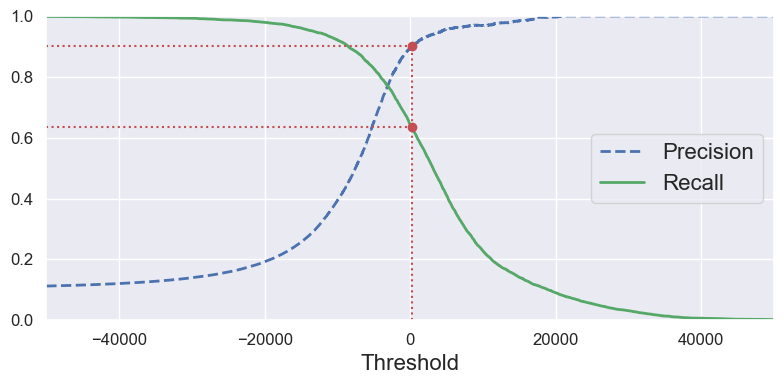

In [568]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [569]:
(y_train_pred == (y_scores > 0)).all()

True

#### Plotting precision directly against recall

Saving figure precision_vs_recall_plot


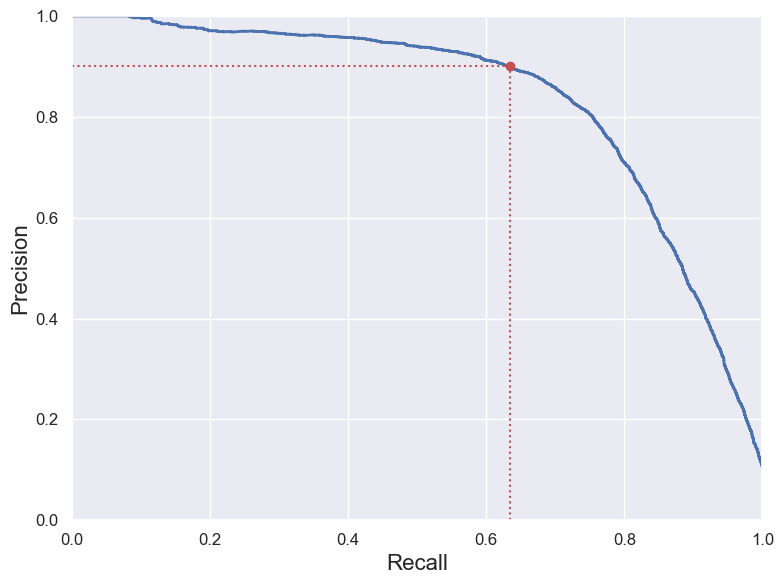

In [570]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [571]:
### Aim for 90% precision

In [572]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [573]:
threshold_90_precision

223.21563016379116

In [574]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [575]:
precision_score(y_train_3, y_train_pred_90)

0.9000462748727441

In [576]:
recall_score(y_train_3, y_train_pred_90)

0.6344805088892513

In [577]:
### Ensured precision at 90% but recall dropped as a result - depends on context - child safety videos vs shoplifting example

### The ROC Curve

#### The receiver operating characteristics (ROC) curve is another common tool used within binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision against recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The ROC curve plots sensitivity (recall) vs 1 - specificity. Similarly a trade-off.

In [578]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

Saving figure roc_curve_plot


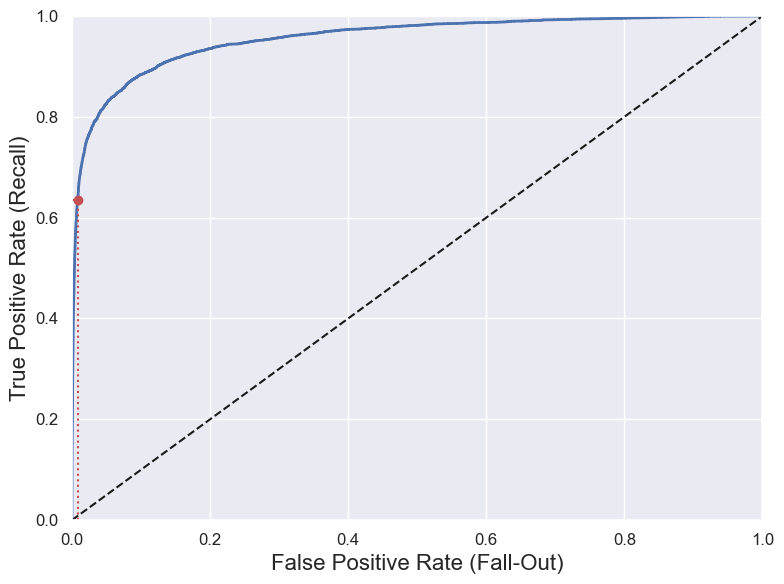

In [579]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

#### One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier would have a AUC as 1, and purely random would = 0.5

In [580]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_3, y_scores)

0.9557785844968288

#### So similar, which to use? Rule of thumb, I should prefer the PR curve is the positive class is rare or when you care more about the false posotivies than the false negatives. Otherwise, use the ROC curve. 

### Create Random Forest classifier and compare to SGD classifier for (not the PR curve)  the ROC curve and the ROC AUC score
#### some classifiers use predict_proba instead of decision function but can use probabilities in ROC

In [581]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=69)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3,
                                    method="predict_proba")

In [582]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3,y_scores_forest)

Saving figure roc_curve_comparison_plot


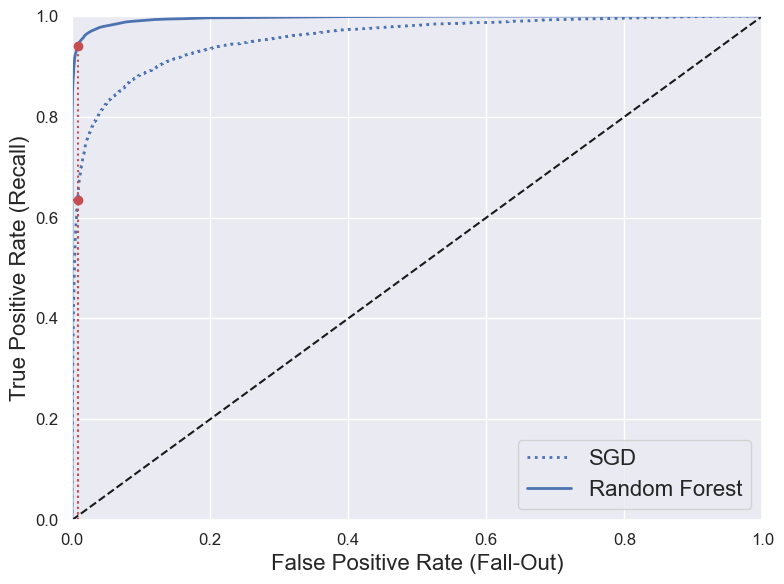

In [583]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [584]:
roc_auc_score(y_train_3, y_scores_forest)

0.995955558764908

In [585]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)
precision_score(y_train_3, y_train_pred_forest)

0.993751220464753

In [586]:
recall_score(y_train_3, y_train_pred_forest)

0.8300440384929049

## Multi-class Classification

In [587]:
## Multi-class classifiers (also called multi-nomial classifiers) can distinguish between more than 2 classes
## Some classifiers (SGD classifiers, Random forest classifiers and naive bayes classifiers) are capable of handling multiple classes natively
## Other classifiers (Logistic Regression or support vector machines) are strictly biinary classifiers, but there's startegie to conduct multioutput classification on binary classifiers
## One-verses-rest (make 9 individual classifiers and pick the one with highest score. Another is one-verses-one where train for each pair of binary Means a lot of classifiers, but each only needs to bve trained on a small section of the data
## SVMs scale poorly for O-V-O is preffered as faster to train, most o-v-r is preffered.

#### SVM Example

In [588]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=69)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([3], dtype=uint8)

In [589]:
## This gives one score per class (9.2 for 3)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  9.2974869 ,  5.8885703 ,
         0.78950589,  1.79862509,  8.10392157, -0.22784964,  4.83753243]])

In [590]:
np.argmax(some_digit_scores)

3

In [591]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [592]:
svm_clf.classes_[3]

3

##### Can force to either make classifier perfrom OVR or OVO
##### OvR below

In [593]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([3], dtype=uint8)

In [594]:
len(ovr_clf.estimators_)

10

#### SGD Example - automatically classifies instances into multiple classes

In [595]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [596]:
sgd_clf.decision_function([some_digit])

array([[-35455.92980802, -13190.40177903, -11016.38348351,
          8399.93131906, -18783.41056522, -19149.43857834,
        -39710.4296111 , -21598.99101084, -11359.12485784,
        -33255.00458709]])

In [597]:
## Using Cross val Score to evaluate the classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87495, 0.87085, 0.8777 ])

In [598]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9069 , 0.89885, 0.90735])

### Error Analysis
#### Have found a promising model and want to improve it. One way is to analyse the type of errors it got.

In [599]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5607,    0,   25,    8,    9,   56,   37,    6,  173,    2],
       [   0, 6420,   44,   24,    5,   48,    4,    9,  175,   13],
       [  30,   29, 5297,   93,   71,   29,   71,   42,  284,   12],
       [  25,   18,  130, 5275,    3,  231,   27,   43,  300,   79],
       [  11,   14,   53,   12, 5241,   13,   44,   27,  249,  178],
       [  29,   17,   33,  173,   56, 4568,   77,   17,  379,   72],
       [  31,   16,   49,    2,   41,  100, 5576,    3,   99,    1],
       [  20,   10,   55,   33,   53,   14,    3, 5723,  127,  227],
       [  18,   70,   52,   96,    5,  154,   29,   11, 5358,   58],
       [  24,   20,   31,   67,  122,   44,    1,  183,  260, 5197]])

In [600]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


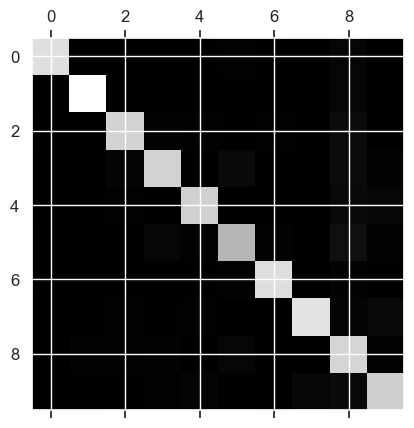

In [601]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [602]:
### 5s look slightly darker than others, so either fewer 5s or classifier doesn't perform well on 5s
### so let's plot the errors

In [603]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


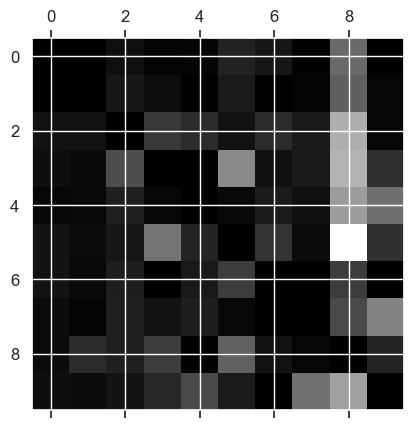

In [604]:
## Remember rows represent actual values and columns represent predicted values
## 8s are bright for a lot of values, so should spend time reducing the false 8s. Could gather more data for digits that look like 8 but are not or engineer new features that would help the classifier (count the number of closed loops), or pre-process

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

NameError: name 'plot_digits' is not defined

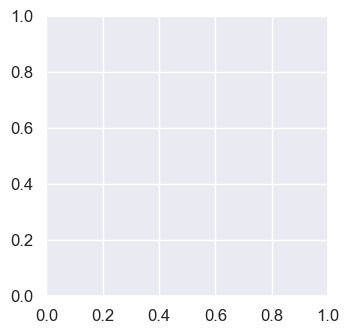

In [525]:
## Find examples visually

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()


In [ ]:
## Reason the errors are here are because we used a simple SGDClassifier, which is a linear model - doesn't assign a wieght to each pixel

### Multilabel Classification

#### Untill now, each instance has always been assigned to just one class. Sometimes you want your classifier to output multiple classes for each instance
#### What is a picture recognised multiple people? Multilabel classification

In [605]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [606]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [607]:
## Compute the f1 score and make average (assumes all labels are equally as important
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### Multilabel Classification

#### Last type of classification task we're talking about is the multioutput-multiclass classification (multioutput classification)
#### It is simply a generalisation of multilabel classification where each label can be multiclass (more than 2 values)

In [608]:
## Remove noise and make each label have pixel intensity (multioutput)

In [609]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


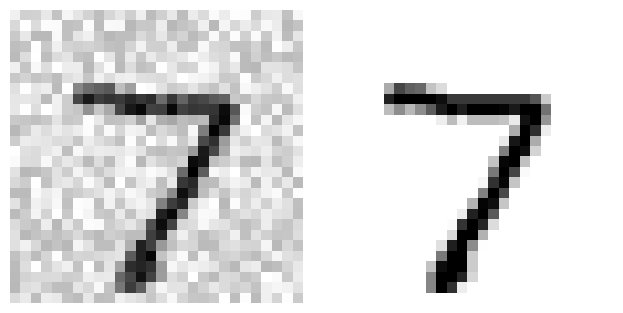

In [610]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


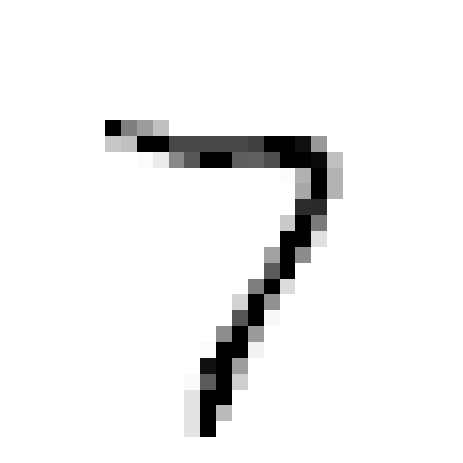

In [611]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

### Dummy (ie. random) classifier

In [612]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_3, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

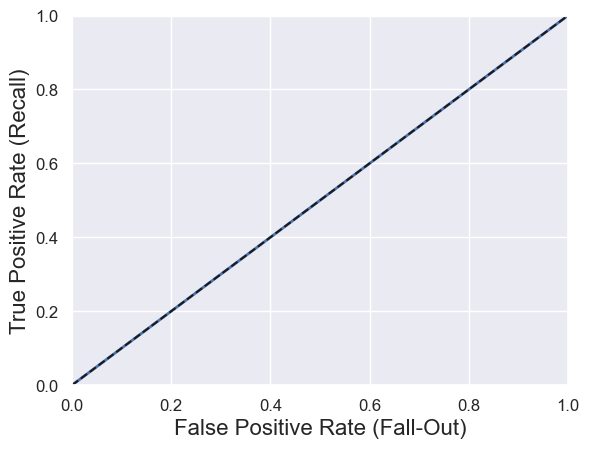

In [613]:
fprr, tprr, thresholdsr = roc_curve(y_train_3, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN classifier

In [614]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [615]:
y_knn_pred = knn_clf.predict(X_test)

In [616]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

/var/folders/j6/wgmktnvs1yz0xntx2vt1_73h0000gn/T/ipykernel_23734/3518175631.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


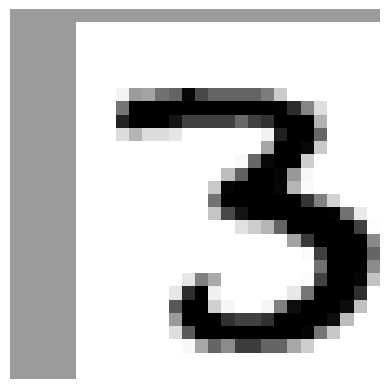

In [617]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [618]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [619]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [620]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [621]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [622]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

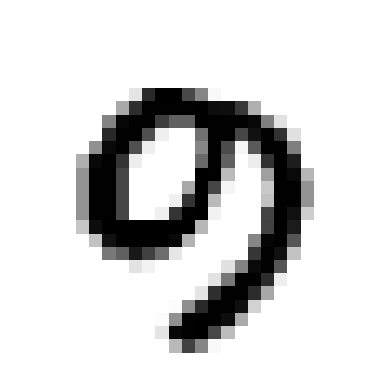

In [623]:
plot_digit(ambiguous_digit)

### Exercises

#### 1) Try to build a classifier for the MNSIT dataset that achieves over 97% accuracy on the test set

In [624]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  11.8s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  13.1s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  12.4s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  11.7s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  12.1s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  12.8s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  12.8s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  13.0s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  13.1s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  13.4s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  13.9s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [640]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [641]:
grid_search.best_score_

0.9716166666666666

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

#### 2. Data Augmentation
#### Write a function that can shift an MNIST image in any direction by one pixel. Then, for each image in the training set, create four shifted copies (one in each direction) and add them to the training set
#### Train best model on this expanding dataset and measure accruacy on test set. Performs better now, this is called data augmentation or data set expansion

In [ ]:
from scipy.ndimage.interpolation import shift

/var/folders/j6/wgmktnvs1yz0xntx2vt1_73h0000gn/T/ipykernel_23734/987197595.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

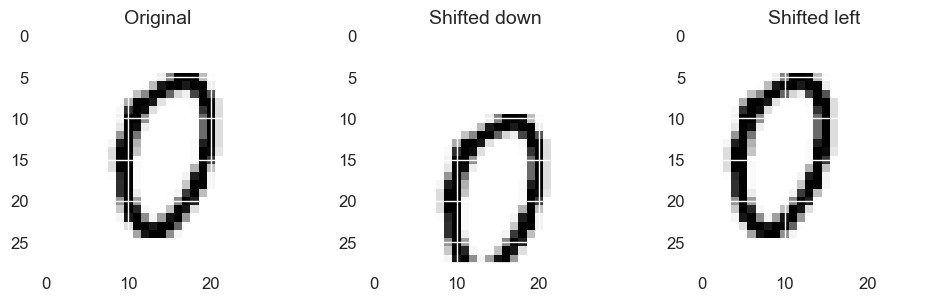

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [639]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

# 3. Tackle the Titanic dataset

## Load the Dataset

In [580]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [581]:
## Download the data

## Load the data into the train and test set 

In [582]:
train = load_titanic_data('train.csv')
test = load_titanic_data('test.csv')

In [583]:
# The data is already split into a training set and a test set. 
# However, the test data does not contain the labels: your goal is to train the best model you can using the training data,
# then make your predictions on the test data and upload them to Kaggle to see your final score.

## Initial look into the train set|

In [584]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [585]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [586]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Initial Investigation - Some Visualisations

#### Trying some countplots

<Axes: xlabel='Pclass', ylabel='count'>

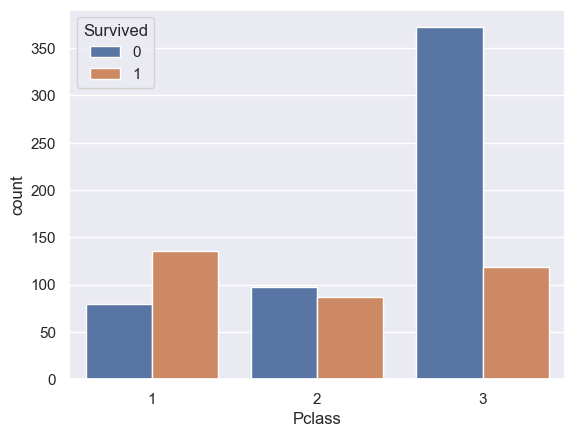

In [587]:
sns.countplot(data=train,x="Pclass",hue="Survived")

<Axes: xlabel='count', ylabel='SibSp'>

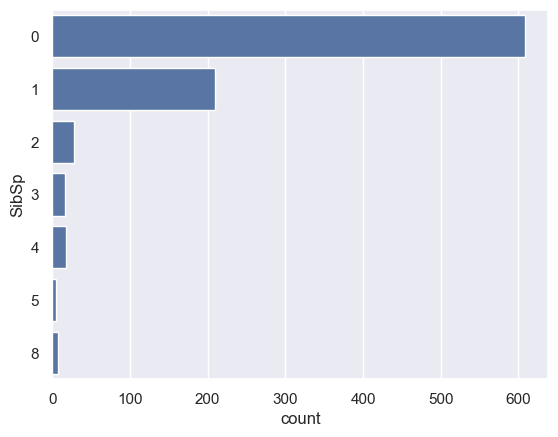

In [588]:
sns.countplot(data=train, y="SibSp")

<Axes: xlabel='count', ylabel='Survived'>

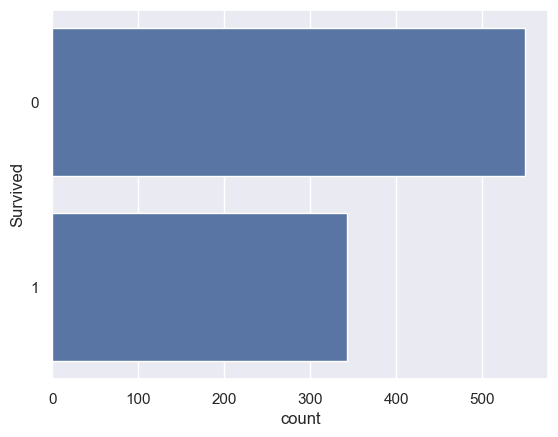

In [589]:
sns.countplot(data=train, y="Survived")

#### Trying a Lineplot

<Axes: xlabel='Pclass', ylabel='Survived'>

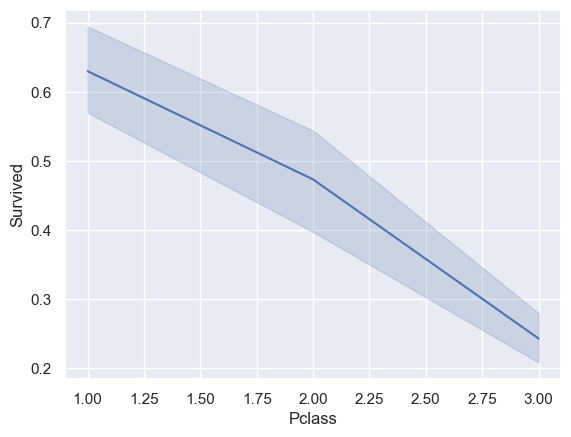

In [590]:
sns.lineplot(data=train,x="Pclass",y='Survived')

##### Percentage of ages that survived

In [591]:
sum_age = sum(train['Age'])

In [592]:
pct_age_survived = train['Pclass']/train['Pclass']+train['Age']

array([[<Axes: title={'center': '0'}>]], dtype=object)

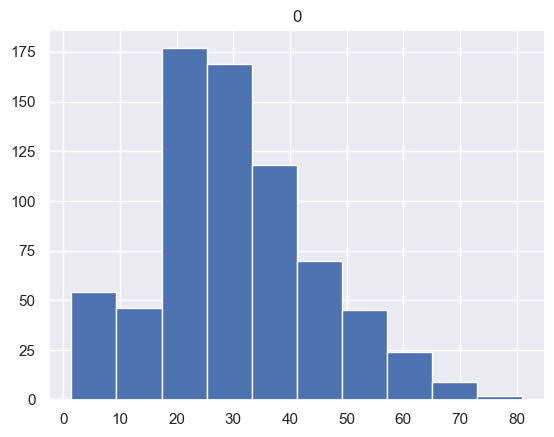

In [593]:
pct_age_survived.to_frame().hist()

##### Easier to do this with seaborn

<Axes: xlabel='Age', ylabel='Density'>

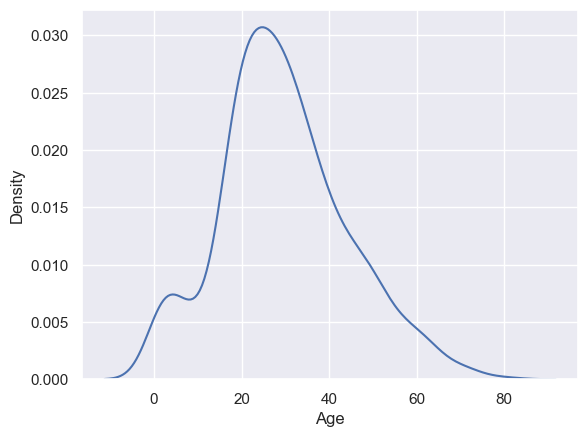

In [594]:
# Import seaborn
#!pip install seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.kdeplot(data=train, x="Age")

##### Trying a few other seaborn plots

<Axes: xlabel='Age', ylabel='Fare'>

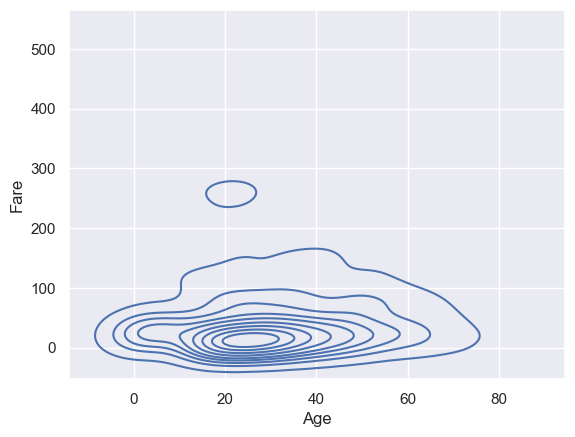

In [595]:
# Shows there were a few of 21ish year olds who paid 
sns.kdeplot(data=train, x="Age", y="Fare")

<Axes: xlabel='Survived', ylabel='Fare'>

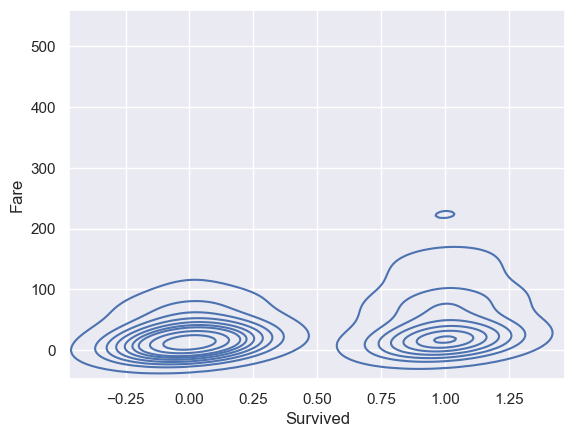

In [596]:
# More likely to survive if you paid a premium
sns.kdeplot(data=train, x="Survived", y="Fare")

<Axes: xlabel='Fare', ylabel='Age'>

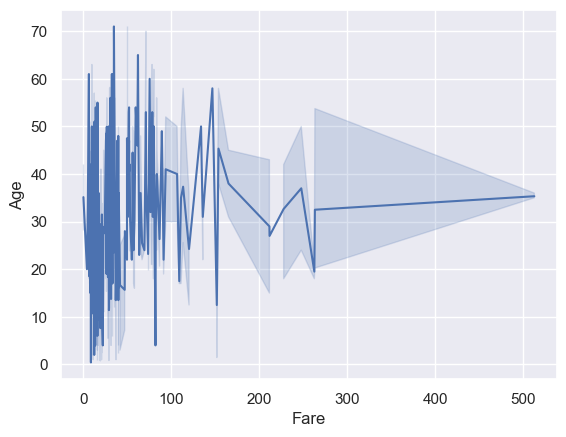

In [597]:
# Don't like this, though looks cool as scroll up and include the 'eyes'
sns.lineplot(x = train["Fare"], y=train["Age"])

# Preparation¡¡¡

# Transform - Transform the dataframe into a num pre-processing and categ pre-processing stages and eventual pipeline 

## Numerical first! - can clean & (standardise or normalise) for numerical, can use one-hot or dummy encoding
### Should really ?¡ do correlation matrix before if the matrix can choose between physical and numeeric

### 0. Deal with N/As

In [598]:
## Fill in N/A with mean... not good practice

In [599]:
# Only Age with N/As
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64

In [600]:
#NOT A GOOD PRACTISE

df['Age'].fillna(df.Age.median(),inplace=True)
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [601]:
df = train

In [602]:
#Make a correction matrix
df

# Did it above - Find only numerical values
df = df.drop(columns=['Name', 'Sex','Ticket','Cabin','Embarked'],axis=1)

In [603]:
### Do we need to transform all categorical variables? - probably yes. How do you do this?

## from sklearn.preprocessing import LabelEncoder ??? - look at a tutorial on label encoder. At what stage do you do this?
## Do you do this before you normalise? - I guess, do you want to normalise the columns? - Depends if they turn into separate columns or into a scale between 0 and 1?

## Correlation Matrix
### Further investigate - Make a correction matrix! (of numeric values)
### Shows relationships nicely - could improve this by transforming categorical columns too

### Should really do this before preparation (before cleam, (stand / normal), or encode - can do this if correlation matrix automatically only picks numeric values, may have to only select numerical if it doesn't automatically choose numeric (if includes categorical)

In [604]:
# Describe
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [605]:
# Create correlation matrix
corr = df.corr()

In [606]:
corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096066
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096066,0.159651,0.216225,1.000000


<Axes: >

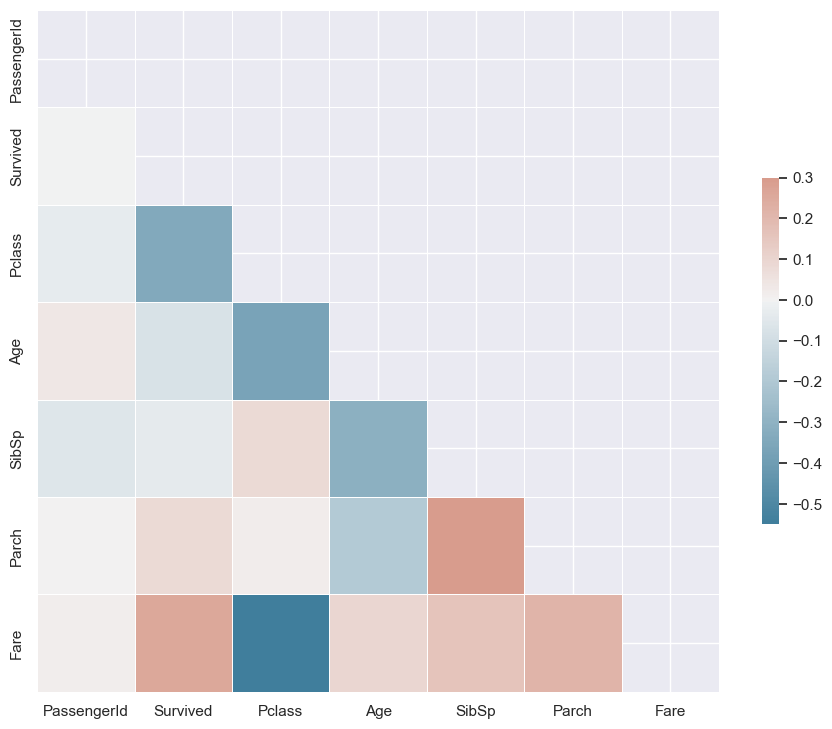

In [607]:
# Make it look pretty and plot the heatmap
from string import ascii_letters

# Make a mask for top right triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [608]:
## Interesting insights can be derived here. 
# Starting with Survived, more likely to survive if you paid a higher fare. You are also more likely to survive if you if you are upper class (1).
# You younger you are, the more parents of children you have (families), are also positively, though quick weak-strengthed, correlated with surviving.
# There is a strong correlation that you will be first class, that you will pay quite a lot (obviously)

In [648]:
train["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [649]:
train["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [650]:
train["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [651]:
train["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

## Standardization & Normalization

#### Transformation is a highly essential step required for any data science project. There is a significant boost in terms of performance of a model from transformation.
#### Normalization rescales the values into a range of [0,1]. also called min-max scaled. 
#### Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1.So it gives a normal graph.

#### It is important to note that standardization should only be applied to continuous variables. 
#### For categorical variables, one-hot encoding or dummy encoding should be used instead
#### So, continue with the numerical variables for now, then one-hot code categorical, and join back together

### Numerical Attributes

In [652]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [660]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [654]:
## Now do label encoder or a different method (one-hot, standardscaler, min-max scaler??) instead of the same LabelEncoder

In [655]:
### What is Label encoder? - only does labels? - what about data (mixmax e.g.)? have to do both or can only do one?

### Categorical Attributes

In [656]:
from sklearn.preprocessing import OneHotEncoder

In [662]:
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

### Join Numeric and Categorical

In [664]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

#### Fit and Transform

In [666]:
X_train = preprocess_pipeline.fit_transform(
    train[num_attribs + cat_attribs])
X_train

/Users/maxsmith/my_env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [668]:
y_train = train["Survived"]

### Train Classifiers

#### Try a Random Forest

In [670]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=69)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=69)

In [672]:
X_test = preprocess_pipeline.transform(test[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

### Cross-validation

In [673]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137827715355807

#### Try an SVC

In [674]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

#### Plot the results of both classifiers

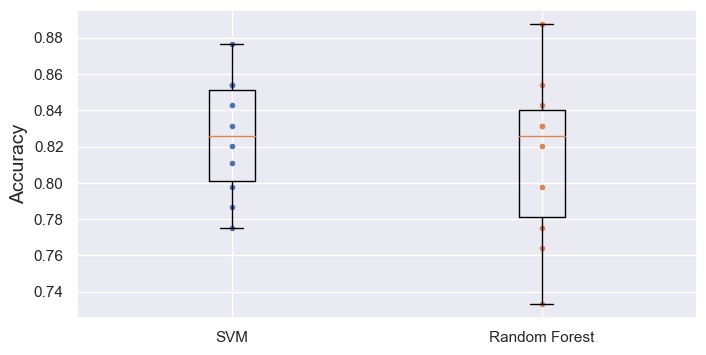

In [676]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [677]:
### Improve

In [678]:
train["AgeBucket"] = train["Age"] // 15 * 15
train[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [679]:
train["RelativesOnboard"] = train["SibSp"] + train["Parch"]
train[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


### 4. Build a spam classifier

In [680]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [681]:
fetch_spam_data()

In [682]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [683]:
len(ham_filenames)

2500

In [684]:
len(spam_filenames)

500

In [685]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [686]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [687]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [688]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [689]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [690]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [691]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [692]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [693]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [694]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [695]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [696]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [697]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HR>
<html>
<div bgcolor="#FFFFCC">

  <p align="center"><a
href="http://www.webbasedmailing.com"><img border="0"
src="http://www.webbasedmailing.com/Toners2goLogo.jpg"
width="349" height="96"></a></p>
<p align="center"><font size="6" face="Arial MT
Black"><i>Tremendous Savings</i>
on Toners,&nbsp;</font></p>
<p align="center"><font size="6" face="Arial MT
Black">
Inkjets, FAX, and Thermal Replenishables!!</font></p>
<p><a href="http://www.webbasedmailing.com">Toners 2 Go
</a>is your secret
weapon to lowering your cost for <a
href="http://www.webbasedmailing.com">High Quality,
Low-Cost</a> printer
supplies!&nbsp; We have been in the printer
replenishables business since 1992,
and pride ourselves on rapid response and outstanding
customer service.&nbsp;
What we sell are 100% compatible replacements for
Epson, Canon, Hewlett Packard,
Xerox, Okidata, Brother, and Lexmark; products that
meet and often exceed
original manufacturer's specifications.</p>
<p><i><font size="4">Check out these
p

In [698]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


   HYPERLINK
Tremendous Savings
on Toners, 
Inkjets, FAX, and Thermal Replenishables!!
 HYPERLINK Toners 2 Go
is your secret
weapon to lowering your cost for  HYPERLINK High Quality,
Low-Cost printer
supplies!  We have been in the printer
replenishables business since 1992,
and pride ourselves on rapid response and outstanding
customer service. 
What we sell are 100% compatible replacements for
Epson, Canon, Hewlett Packard,
Xerox, Okidata, Brother, and Lexmark; products that
meet and often exceed
original manufacturer's specifications.
Check out these
prices!
        Epson Stylus
Color inkjet cartridge
(SO20108):     Epson's Price:
$27.99    
Toners2Go price: $9.95!
         HP
LaserJet 4 Toner Cartridge
(92298A):           
HP's
Price:
$88.99           
Toners2Go
  price: $41.75!
 
Come visit us on the web to check out our hundreds
of similar bargains at  HYPERLINK Toners
2 Go!
  request to be excluded by visiting  HYPERLINK HERE
beverley
 ...


In [699]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [700]:
print(email_to_text(sample_html_spam)[:100], "...")


   HYPERLINK
Tremendous Savings
on Toners, 
Inkjets, FAX, and Thermal Replenishables!!
 HYPERLINK T ...


In [701]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Error: stemming requires the NLTK module.


In [703]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


In [704]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [705]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'NUMBER': 6, 'i': 4, 'a': 4, 'the': 4, 'to': 4, 'of': 3, 'on': 3, 'what': 3, 'and': 3, 'they': 3, 'it': 3, 'you': 3, 'in': 2, 'think': 2, 'was': 2, 'being': 2, 'discussed': 2, 'for': 2, 'wrote': 2, 'directly': 2, 'bot': 2, 'etc': 2, 's': 2, 'going': 2, 'actually': 1, 'thought': 1, 'this': 1, 'kind': 1, 'active': 1, 'chat': 1, 'at': 1, 'aol': 1, 'bringing': 1, 'up': 1, 'ads': 1, 'based': 1, 'other': 1, 'features': 1, 'while': 1, 'vp': 1, 'dev': 1, 'now': 1, 'still': 1, 'cto': 1, 'really': 1, 'hot': 1, 'idea': 1, 'patenting': 1, 'then': 1, 'lost': 1, 'interest': 1, 'probably': 1, 'good': 1, 'thing': 1, 'sdw': 1, 'lorin': 1, 'rivers': 1, 'pm': 1, 'mr': 1, 'fork': 1, 'fork_list': 1, 'hotmail': 1, 'com': 1, 'about': 1, 'situation': 1, 'where': 1, 'don': 1, 't': 1, 'ask': 1, 'talk': 1, 'but': 1, 'listen': 1, 'advise': 1, 'correct': 1, 'interject': 1, 'example': 1, 'two': 1, 'people': 1, 'discussing': 1, 'trips': 1, 'may': 1, 'trigger': 1, 'weather': 1, 'mention': 1, 'forecast

In [706]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [707]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [708]:
X_few_vectors.toarray()

array([[117,   6,   4,   3,   4,   4,   1,   1,   2,   4,   3],
       [245,   1,  24,  10,   8,   7,   8,   8,   6,   3,   4],
       [ 81,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [709]:
vocab_transformer.vocabulary_

{'NUMBER': 1,
 'the': 2,
 'of': 3,
 'a': 4,
 'to': 5,
 'is': 6,
 'that': 7,
 's': 8,
 'i': 9,
 'you': 10}

In [710]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [711]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.990) total time=   0.4s
[CV] END ................................ score: (test=0.973) total time=   0.2s
[CV] END ................................ score: (test=0.983) total time=   0.2s


0.9816666666666666

In [712]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 97.06%
Recall: 95.19%
